# Trabalho 3

Bianca Nunes Coelho - 15102880<br>
Raíssa Nunes Coelho - 15102887<br>

## Introdução
No cenário atual de constante fluxo de informações, o jornalismo desempenha um papel crucial na disseminação de notícias e na formação de opinião pública. Com a crescente quantidade de conteúdo jornalístico disponível online, surge a necessidade de técnicas automatizadas para organizar e classificar essas informações de maneira eficiente. Neste projeto, propomos explorar o uso do Processamento de Linguagem Natural (PLN) para classificar textos de matérias jornalísticas de jornais brasileiros, visando aprimorar a organização e a acessibilidade desse conteúdo. <br>

A calssificação de texto é necessária para automatizar a organização e a análise de grandes volumes de dados textuais. A classificação de textos jornalísticos possibilita uma melhor organização do conteúdo, tornando-o mais acessível e útil para os leitores. Além disso, a classificação automática é essencial para a criação de sistemas de recomendação personalizados e para o desenvolvimento de ferramentas de análise de sentimentos e tendências.<br>

O principal objetivo deste projeto é desenvolver modelos de PLN capazes de classificar automaticamente textos de matérias jornalísticas em categorias pré-definidas. Essa classificação facilitará a indexação e a recuperação de informações relevantes, além de permitir análises mais aprofundadas sobre tendências e padrões presentes nas notícias. Assim, buscamos:<br>

  +  Implementar e avaliar diferentes algoritmos de classificação, como Naive Bayes, SVM e Árvores de Decisão. <br>
  +  Analisar e interpretar os resultados obtidos em relação aos objetivos do projeto e às perguntas centrais formuladas. <br>
Para orientar a nossa pesquisa e análise as seuintes perguntas são centrais: <br>
  + Quais algoritmos de classificação de textos apresentam melhor desempenho na identificação de categorias de matérias jornalísticas?
  + Como os resultados obtidos podem contribuir para aprimorar a organização e a acessibilidade do conteúdo jornalístico online?

## Bibliotecas
Bibliotecas necessárias para execução básica dos códigos ficam aqui. Outras são chamadas quando necessário.

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

## Dataset

O dataset está em formato *parquet*, que é mais eficiente, rápido e compacta mais o tamanho do arquivo. Para ler parquet precisamos de uma engine além do pandas, a escolhida foi pyarrow.</br>

O arquivo de dataset contém matérias jornalisticas tiradas do website CNN Brasil em 2023 no espaço de 1 mês. O autor do dataset se encontra no site da Hugging Face neste link: [cnn_news_ptbr](https://huggingface.co/datasets/celsowm/cnn_news_ptbr).</br>

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


Como pode-se ver, o dataset possui 3877 linhas e 6 colunas sendo elas: "titulo", "texto", "link", "resumo", "categoria" e "data_hora".

## Balanceamento

O balanceamento de um conjunto de dados é um passo crucial no pré-processamento, especialmente em problemas de classificação onde as classes estão desproporcionalmente representadas. Então, mesmo tendo um dataset pronto para o treinamento de modelos de classificação, precisamos verificar e balanceá-lo para que se diminua desvios e viés ao final do treinamento.</br>

In [5]:
df['categoria'].value_counts()

categoria
esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: count, dtype: int64

<Axes: xlabel='categoria'>

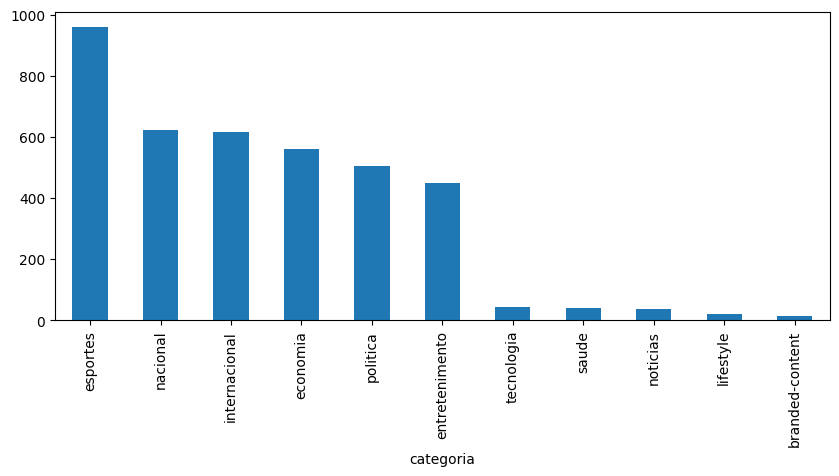

In [6]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

Pelo gráfico de barras acima, os dados do dataset estão muito desbalanceados. Foi decidico a exclusão das quatro menores categorias, já que não iremos injetar outros dados jornalisticos no dataset.

In [7]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [8]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [9]:
df['categoria'].value_counts()

categoria
esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: count, dtype: int64

Após a remoção das categorias, o dataset ainda precisa que elas estejam balanceadas por número de exemplos, ou seja, elas precisam ter o mesmo número de textos para cada. Assim, é feito o undersampling que consiste em reduzir o número de instâncias da classe majoritária para igualar ao número da classe minoritária. Neste caso usamos o min para "cortar" todas categorias pela menor delas: entretenimento.

In [10]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [11]:
df_balanceado['categoria'].value_counts()

categoria
esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: count, dtype: int64

In [12]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Racismo e xenofobia: torcedor do Boca imita ma...,"Um torcedor do Boca Juniors imitou um macaco, ...",https://www.cnnbrasil.com.br/esportes/racismo-...,Boca Juniors e Fluminense decidem a Copa Liber...,esportes,2023-11-04 19:14:18
1,Donuts e 9 pães: veja dieta de Ramon Dino no d...,O brasileiro Ramon Dino foi 2º colocado do Mr....,https://www.cnnbrasil.com.br/esportes/donuts-e...,Atleta é um dos principais nomes do fisicultur...,esportes,2023-11-11 17:00:36
2,Trilha do EA Sports FC 24 ganha nova música br...,"Dois meses após o lançamento, o EA Sports FC 2...",https://www.cnnbrasil.com.br/esportes/trilha-d...,Kit de uniforme dos Rolling Stones também está...,esportes,2023-11-21 21:38:23
3,"Sem ídolos, Romário diz que craque atleticano ...",Lendário camisa 11 da Seleção Brasileira e ído...,https://www.cnnbrasil.com.br/esportes/sem-idol...,Tetracampeão do mundo com a Seleção Brasileira...,esportes,2023-11-21 12:14:51
4,Por que Kim Kardashian “surtou” ao encontrar E...,"Nos últimos meses, a socialite Kim Kardashian ...",https://www.cnnbrasil.com.br/esportes/por-que-...,"Socialite leva o filho, Saint West, a vários j...",esportes,2023-11-16 19:10:33


In [13]:
text = df_balanceado['texto'] # para NLTK
len(text)

2700

Com o dataset balanceado, agora temos 2700 linhas para o treinamento e teste dos modelos.

## Pré-processamento
Pré-processamento de dados, no contexto de ciência de dados e aprendizado de máquina, refere-se ao conjunto de técnicas e etapas aplicadas aos dados brutos antes de serem usados. E essencial ter os dados do dataset pre-processados para retirar palavras, simbolos e números que não serão úteis para a classificação de texto. Palavras chaves são mais úteis para a classificação de documentos.<BR>

As técnicas utilizadas de pré-processamento foram:</br>
+ Normalização: transformar todas as letras de um texto em minúsculas.</br>
+ Remoção de acentos das palavras com unidecode.</br>
+ Remoção de Pontuação, Caracteres Especiais e Números com Regex.</br>
+ Tokenização: Divisão de texto em tokens (palavras, frases, caracteres).</br>
+ Remoção de Stopwords: Eliminação de palavras comuns que não contribuem para a análise.</br>

In [14]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [15]:
from unidecode import unidecode
# retirada de acentos
for i in range(len(text)):
    text[i] = unidecode(text[i])

In [16]:
# retirada de caracteres especiais
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [17]:
token_text = []

# tokenização
for j in text:
    token_text.append(nltk.word_tokenize(j))

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/raissa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
# retirada de stopword com o corpus do NLTK
sw = stopwords.words('portuguese')

In [20]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

Testes anteriores mostraram que apenas retirar stopwords com o uso do NLTK podem ser ruins para algumas palavras. Isso acontece porque o *corpus* do NTLK em português apenas considera as palavras mais usadas. No contexto de jornais, palavras muito usadas podem ser diferentes, dependendo da categoria e do veiculo utilizado para a retirada das notícias. Como o dataset foi retirado de um web site, a palavra "leia" aparece muitas vezes, provavelmente para significar um link de continuação para ler outras notícias. Então, essa palavra precisa ser retirada do texto. </br>
Abaixo foi feito um código com palavras comuns que apareceram nos testes passados e a sua retirada do texto.

In [21]:
stopwords2 = ["podera", "ja", "assim","dessa","antes","sobre","vai","h","horario","quanto",
              "pode", "tambem", "disso", "ate","leia", "sobre", "contra", "outra", "tera", 
              "nao", "porque","entao", "fim", "ha", "muita", "bem", "assuma", "parece", "chance",
              "diz", "bom", "soma", "mesmos", "p", "mau", "uol", "nada", "desse", "deram"]

for stop in stopwords2:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [22]:
print(token_text[100])

['atacante', 'gabriel', 'barbosa', 'gabigol', 'usou', 'twitter', 'nesta', 'quartafeira', 'parabenizar', 'flamengo', 'aniversario', 'anos', 'entanto', 'jogador', 'causou', 'polemica', 'publicacao', 'gerou', 'diversos', 'comentarios', 'web', 'repercussao', 'ruim', 'deu', 'foto', 'atacante', 'publicou', 'lado', 'zico', 'maiores', 'idolos', 'historia', 'clube', 'dois', 'estao', 'sentados', 'tronos', 'zico', 'rei', 'gabigol', 'lado', 'entanto', 'gabriel', 'duas', 'tacas', 'libertadores', 'colo', 'enquanto', 'zico', 'somente', 'parabens', 'flamengo', 'anos', 'crf', 'pictwittercomwdomymjjcb', 'gabriel', 'barbosa', 'gabigol', 'november', 'imagem', 'acordo', 'alguns', 'torcedores', 'passa', 'impressao', 'comparacao', 'dois', 'gabigol', 'maior', 'zico', 'momento', 'atacante', 'vive', 'grande', 'fase', 'equipe', 'carioca', 'torcida', 'flamengo', 'ficou', 'feliz', 'publicacao', 'criticou', 'atacante', 'comentarios', 'faltou', 'colocar', 'colo', 'zico', 'taca', 'campeao', 'mundial', 'escreveu', 'in

In [23]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Racismo e xenofobia: torcedor do Boca imita ma...,"[torcedor, boca, juniors, imitou, macaco, prov...",https://www.cnnbrasil.com.br/esportes/racismo-...,Boca Juniors e Fluminense decidem a Copa Liber...,esportes,2023-11-04 19:14:18
1,Donuts e 9 pães: veja dieta de Ramon Dino no d...,"[brasileiro, ramon, dino, colocado, mr, olympi...",https://www.cnnbrasil.com.br/esportes/donuts-e...,Atleta é um dos principais nomes do fisicultur...,esportes,2023-11-11 17:00:36


Com tudo feito, o texto está pronto para o treinamento e vetorização.

## Treinamento dos Modelos

O treinamento de modelos é uma etapa crucial no desenvolvimento de sistemas de aprendizado de máquina. Durante o treinamento, o modelo é exposto a um conjunto de dados de treinamento para aprender a relação entre as entradas (características) e as saídas (rótulos) dos dados.</br>
Antes dos modelos serem treinados, é necessário fazer a vetorização do dataset. Utilizazmos BoW e TF-IDF.</br>
+ BoW(*Bag of Words*): representa cada documento de texto como um vetor numérico onde cada dimensão é uma palavra específica do corpus e o valor poderia ser sua frequência no documento, ocorrência (indicada por 1 ou 0), ou até mesmo valores ponderados. Não considera a ordem e posição das palavras.
+ TF-IDF(*Term Frequency–Inverse Document Frequency*): relata a importância de uma palavra em um documento. TF-IDF é o produto da Frequência do Termo e da Frequência Inversa do Documento.

### NLTK e Vetorização
A vetorização refere-se ao processo de representar dados de texto (como palavras, frases ou documentos) como vetores numéricos. Esse processo é essencial porque a maioria dos algoritmos de aprendizado de máquina e técnicas de PLN requerem que os dados de entrada sejam numéricos.</br>
Primeiro juntamos os textos em uma string para cada um, e colocado de volta no dataset.

In [24]:
for i in range(len(token_text)):
    token_text[i] = " ".join(token_text[i])
print(token_text[0])

torcedor boca juniors imitou macaco provocacao brasileiros durante entrada vivo emissora argentina tn entorno maracana neste sabado final copa libertadores post shared by itatiaia esporte itatiaiaesporte reportagem registrava reclamacoes argentinos lado estadio forma recebidos policia militar rio janeiro torcedor surgiu comecou fazer gestos macaco xingar brasileiros diante grande volume torcedores boca desorganizacao acesso maracana pm disparou tiros balas borracha bombas efeito moral correcorre pessoas passando mal


In [25]:
df_balanceado['texto'] = token_text
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Racismo e xenofobia: torcedor do Boca imita ma...,torcedor boca juniors imitou macaco provocacao...,https://www.cnnbrasil.com.br/esportes/racismo-...,Boca Juniors e Fluminense decidem a Copa Liber...,esportes,2023-11-04 19:14:18
1,Donuts e 9 pães: veja dieta de Ramon Dino no d...,brasileiro ramon dino colocado mr olympia prin...,https://www.cnnbrasil.com.br/esportes/donuts-e...,Atleta é um dos principais nomes do fisicultur...,esportes,2023-11-11 17:00:36
2,Trilha do EA Sports FC 24 ganha nova música br...,dois meses apos lancamento ea sports fc sucess...,https://www.cnnbrasil.com.br/esportes/trilha-d...,Kit de uniforme dos Rolling Stones também está...,esportes,2023-11-21 21:38:23
3,"Sem ídolos, Romário diz que craque atleticano ...",lendario camisa selecao brasileira idolo vasco...,https://www.cnnbrasil.com.br/esportes/sem-idol...,Tetracampeão do mundo com a Seleção Brasileira...,esportes,2023-11-21 12:14:51
4,Por que Kim Kardashian “surtou” ao encontrar E...,ultimos meses socialite kim kardashian levado ...,https://www.cnnbrasil.com.br/esportes/por-que-...,"Socialite leva o filho, Saint West, a vários j...",esportes,2023-11-16 19:10:33


É selecionado a coluna categoria e a coluna texto e criado um novo dataset.

In [26]:
col = ['categoria', 'texto']
df_balanceado = df_balanceado[col]

In [27]:
df_balanceado.head()

,categoria,texto
0,esportes,torcedor boca juniors imitou macaco provocacao...
1,esportes,brasileiro ramon dino colocado mr olympia prin...
2,esportes,dois meses apos lancamento ea sports fc sucess...
3,esportes,lendario camisa selecao brasileira idolo vasco...
4,esportes,ultimos meses socialite kim kardashian levado ...


É adicionada a categoria ID, que representa um número para cada categoria. A numeração começa em zero.

In [57]:
df_balanceado['category_id'] = df_balanceado['categoria'].factorize()[0]
from io import StringIO
category_id_df = df_balanceado[['categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'categoria']].values)
df_balanceado.head(-3)

,categoria,texto,category_id
0,esportes,torcedor boca juniors imitou macaco provocacao...,0
1,esportes,brasileiro ramon dino colocado mr olympia prin...,0
2,esportes,dois meses apos lancamento ea sports fc sucess...,0
3,esportes,lendario camisa selecao brasileira idolo vasco...,0
4,esportes,ultimos meses socialite kim kardashian levado ...,0
...,...,...,...
2692,entretenimento,apresentadora ana furtado anos publicou video ...,5
2693,entretenimento,fas producoes sulcoreanas agora data comemorar...,5
2694,entretenimento,gwyneth paltrow mostrou nesta quartafeira atua...,5
2695,entretenimento,hoje dia festa nesta sextafeira cantora anitta...,5


Primeiro é feito o TD-IDF do textos e depois os pesos são colocados no BoW.

In [29]:
## Bag of Words model - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=sw)
features = tfidf.fit_transform(df_balanceado['texto']).toarray()
labels = df_balanceado.category_id
features.shape

(2700, 18813)

Abaixo se encontra uso de Bigramas e Unigramas para analisar a correlação entre características (features) e rótulos de classes no dataset balanceado. Cada categoria possui palavras correlacionadas.

In [30]:
## Bigramas e Unigramas
from sklearn.feature_selection import chi2
import numpy as np

N = 2

for categoria, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(categoria))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'economia':
  . Most correlated unigrams:
. tributaria
. bilhoes
  . Most correlated bigrams:
. banco central
. reforma tributaria
# 'entretenimento':
  . Most correlated unigrams:
. fas
. cantora
  . Most correlated bigrams:
. post shared
. shared by
# 'esportes':
  . Most correlated unigrams:
. rodada
. campeonato
  . Most correlated bigrams:
. originalmente itatiaia
. itatiaia versao
# 'internacional':
  . Most correlated unigrams:
. israel
. gaza
  . Most correlated bigrams:
. defesa israel
. faixa gaza
# 'nacional':
  . Most correlated unigrams:
. civil
. policia
  . Most correlated bigrams:
. defesa civil
. policia civil
# 'politica':
  . Most correlated unigrams:
. supremo
. stf
  . Most correlated bigrams:
. supremo tribunal
. tribunal federal


### Treinamento
Nesta etapa encontra-se o treinamento de cada modelo. Usamos a biblioteca *sklearn* para a utilização e treinamento dos modelos. A seguir têm-se os modelos utilizados:</br>
+ Logistic Regression: é um algoritmo usado para prever uma variável baseado em um conjunto de dados de variáveis independentes. O resultado é binário(0 e 1). LR foi construida a partir da aplicação de uma transformação sobre a Regressão Linear.
+ Random Forest Classifier: cria árvores de decisões de maneira aleatória formando uma floresta. Suas previsões são combinadas no resultado final para realizar as previsões. 
+ Multinomial Naive Bayes: é uma variação de Naive Bayes. Para calcular a predição, o algoritmo cria uma tabela de probabilidades, em que consta a frequência deles com relação às variáveis de saída. O calcúlo final leva em conta a probabilidade maior para oferecer uma solução.
+ Linear SVC: é uma versão linear do SVM (*Support Vector Machine*). Ele encontra um hiperplano para maximizar a distâncias entre as amostras já classificadas.
+ Decision Tree Classifier: DTs consistem em uma estrutura de nós conectados por arestas ou ramos, que se assemelha à estrutura de uma árvore. Pode ser utilizada para tarefas de regressão e classificação.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_balanceado['texto'], df_balanceado['categoria'], random_state = 2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(dual=False),
    MultinomialNB(), #Naive Bayes
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(random_state=0,max_depth=10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [34]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.626667
LinearSVC                 0.908519
LogisticRegression        0.900000
MultinomialNB             0.884444
RandomForestClassifier    0.780000
Name: accuracy, dtype: float64

Pode ser visto pela tabela acima que a acurácia de cada modelo difere bastante. Alguns fatores pela grande diferença são a profundidade usada na Decision Tree e Random Forest. Além do estado randomico.</br>
Abaixo têm-se o gráfico representando melhor as diferenças entre os modelos.

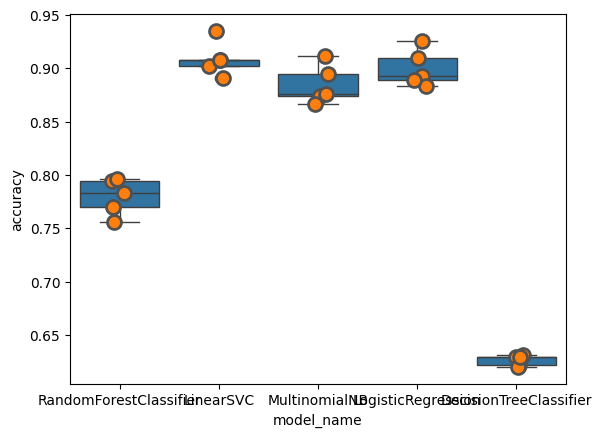

In [35]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, edgecolor="auto", linewidth=2)
plt.show()

Nas próximas seções temos a demonstração, as métricas e predição de cada modelo.

### Multinomial NB

In [36]:
## Multinomial NB
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.93      0.96       140
      nacional       0.84      0.86      0.85       147
 internacional       0.94      0.84      0.89       159
      economia       0.80      0.91      0.85       137
      politica       0.84      0.78      0.81       141
entretenimento       0.91      0.99      0.95       167

      accuracy                           0.89       891
     macro avg       0.89      0.88      0.88       891
  weighted avg       0.89      0.89      0.89       891



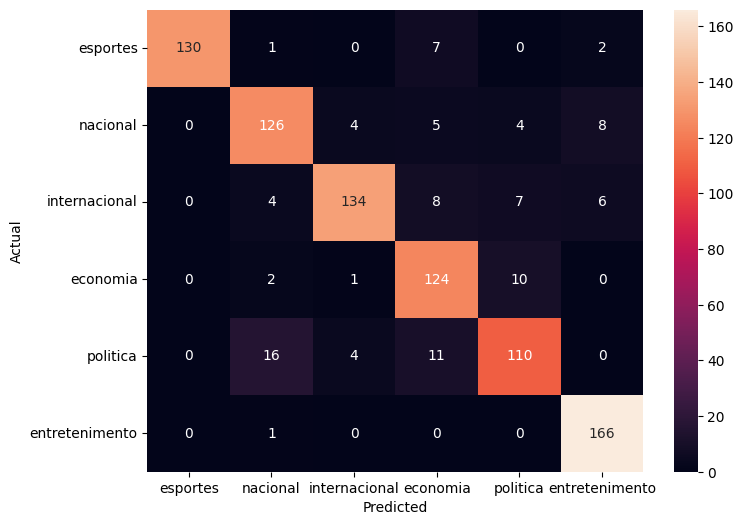

In [38]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### LogisticRegression

In [39]:
from sklearn.model_selection import train_test_split

model2 = LogisticRegression(random_state=0)

X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)

In [40]:
from sklearn import metrics
print(metrics.classification_report(y_test2, y_pred2,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.98      0.99       140
      nacional       0.83      0.88      0.86       147
 internacional       0.96      0.87      0.91       159
      economia       0.86      0.92      0.89       137
      politica       0.90      0.79      0.85       141
entretenimento       0.91      0.98      0.94       167

      accuracy                           0.91       891
     macro avg       0.91      0.91      0.91       891
  weighted avg       0.91      0.91      0.91       891



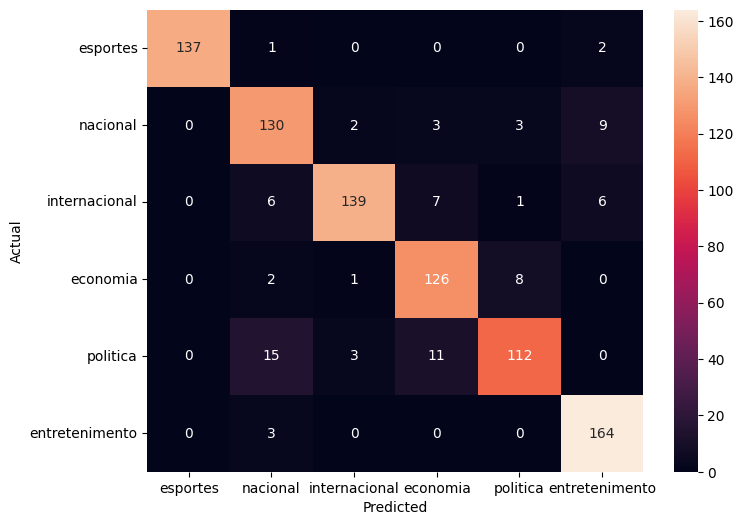

In [41]:
from sklearn.metrics import confusion_matrix

conf_mat2 = confusion_matrix(y_test2, y_pred2)
fig2, ax2 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat2, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Linear SVC

In [42]:
from sklearn.model_selection import train_test_split

model3 = LinearSVC(dual=False)

X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model3.fit(X_train3, y_train3)
y_pred3 = model3.predict(X_test3)

In [43]:
print(metrics.classification_report(y_test3, y_pred3,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.98      0.99       140
      nacional       0.86      0.85      0.86       147
 internacional       0.95      0.89      0.92       159
      economia       0.88      0.95      0.91       137
      politica       0.90      0.81      0.85       141
entretenimento       0.90      0.99      0.94       167

      accuracy                           0.91       891
     macro avg       0.91      0.91      0.91       891
  weighted avg       0.91      0.91      0.91       891



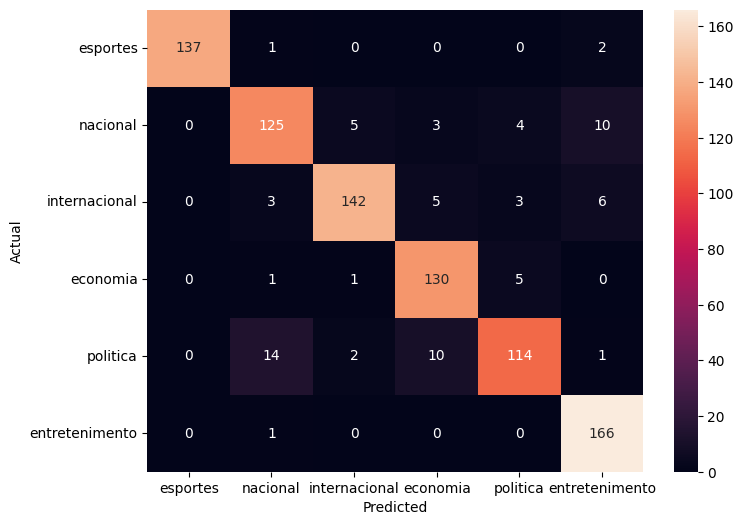

In [44]:
conf_mat3 = confusion_matrix(y_test3, y_pred3)
fig3, ax3 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat3, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

In [45]:
model4 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

X_train4, X_test4, y_train4, y_test4, indices_train4, indices_test4 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model4.fit(X_train4, y_train4)
y_pred4 = model4.predict(X_test4)

In [46]:
print(metrics.classification_report(y_test4, y_pred4,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       0.86      0.84      0.85       140
      nacional       0.61      0.85      0.71       147
 internacional       0.93      0.60      0.73       159
      economia       0.71      0.75      0.73       137
      politica       0.71      0.76      0.73       141
entretenimento       0.88      0.78      0.83       167

      accuracy                           0.76       891
     macro avg       0.78      0.76      0.76       891
  weighted avg       0.79      0.76      0.76       891



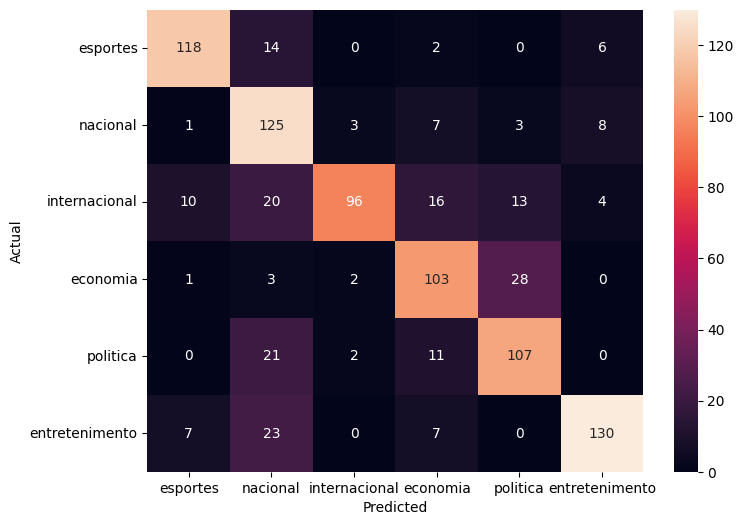

In [47]:
conf_mat4 = confusion_matrix(y_test4, y_pred4)
fig4, ax4 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat4, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Decision Tree

In [48]:
model5 = DecisionTreeClassifier(random_state=0,max_depth=10)

X_train5, X_test5, y_train5, y_test5, indices_train5, indices_test5 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model5.fit(X_train5, y_train5)
y_pred5 = model5.predict(X_test5)

In [49]:
print(metrics.classification_report(y_test5, y_pred5, target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       0.99      0.66      0.79       140
      nacional       0.67      0.52      0.58       147
 internacional       0.95      0.50      0.65       159
      economia       0.47      0.42      0.44       137
      politica       0.75      0.64      0.69       141
entretenimento       0.43      0.93      0.59       167

      accuracy                           0.62       891
     macro avg       0.71      0.61      0.63       891
  weighted avg       0.71      0.62      0.63       891



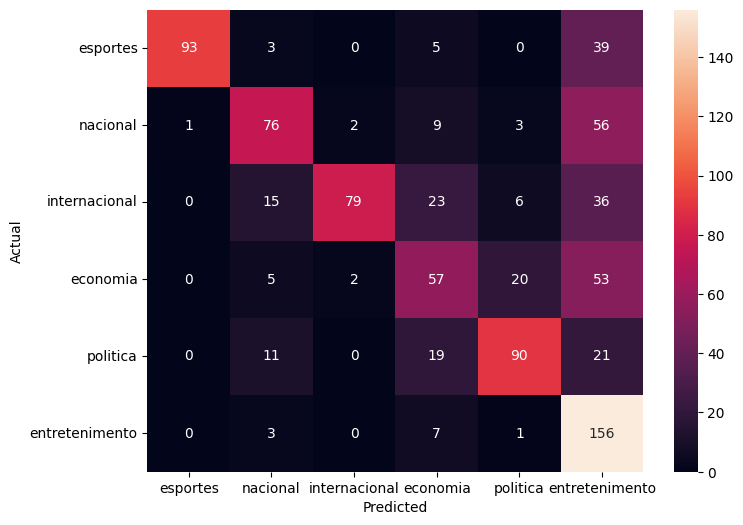

In [50]:
conf_mat5 = confusion_matrix(y_test5, y_pred5)
fig5, ax5 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat5, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testando o(s) Modelo(s)
Aqui encontra-se os testes com textos pegos da CNN para a demonstração de suas acurácias.

### Multinomial NB

In [51]:
texts = [""" França deu o último passo, nesta segunda-feira (4), para se tornar o primeiro país do mundo a prever o acesso ao aborto em sua Constituição.
O Congresso francês, que reúne as duas casas do Parlamento em Versalhes para votação quando há mudanças na Constituição, aprovou por ampla maioria o projeto que constitucionaliza o aborto. Dos 852 deputados e senadores reunidos, 780 votaram a favor e 72 contra.

Após a promulgação pelo presidente francês, o que deve acontecer na sexta-feira (8), Dia da Mulher, o artigo 34.º artigo da Constituição francesa passará a prever a “liberdade garantida da mulher de recorrer ao direito à interrupção voluntária da gravidez [IVG, sigla usada para se referir ao aborto na França]”. 
Raízes históricas por trás da mudança

A decisão, considerada histórica por movimentos feministas e partidos de esquerda, é uma construção de séculos.

A defesa dos direitos femininos na França tem raízes históricas. Já no século XV, a escritora Christine de Pizan defendeu o direito das mulheres à educação. Três séculos depois, Olympe de Gouges criticou a exclusão das mulheres da “Declaração dos Direitos do Homem e do Cidadão” na Revolução Francesa de 1789. E em 1949, no livro “O Segundo Sexo”, Simone de Beauvoir estruturou as bases que definem o feminismo moderno ao discutir a opressão da mulher em um mundo dominado pelo homem.

A França também é o país que, ainda no início do século passado, separou a Igreja do Estado ao aprovar em 1905 a Lei da Laicidade, afastando a religião das discussões políticas. 

Esses são alguns dos fatores que explicam por que 86% dos franceses apoiam a constitucionalização do aborto, como demonstrou uma pesquisa do final de 2022 – taxa bem superior à do Brasil, onde a aprovação ao aborto é de 39%. 

Com o apoio massivo da população francesa, senadores admitiram que votaram a favor do texto para evitar críticas. No último dia 28 de fevereiro, o Senado francês, de maioria direitista, aprovou o projeto por ampla maioria, com 267 votos a favor e 50 contra."""]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [52]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'nacional'


In [53]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


### LogisticRegression

In [59]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features2 = tfidf.transform(texts)
predictions2 = model2.predict(text_features)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [58]:
texts = [""" França deu o último passo, nesta segunda-feira (4), para se tornar o primeiro país do mundo a prever o acesso ao aborto em sua Constituição.
O Congresso francês, que reúne as duas casas do Parlamento em Versalhes para votação quando há mudanças na Constituição, aprovou por ampla maioria o projeto que constitucionaliza o aborto. Dos 852 deputados e senadores reunidos, 780 votaram a favor e 72 contra.

Após a promulgação pelo presidente francês, o que deve acontecer na sexta-feira (8), Dia da Mulher, o artigo 34.º artigo da Constituição francesa passará a prever a “liberdade garantida da mulher de recorrer ao direito à interrupção voluntária da gravidez [IVG, sigla usada para se referir ao aborto na França]”. 
Raízes históricas por trás da mudança

A decisão, considerada histórica por movimentos feministas e partidos de esquerda, é uma construção de séculos.

A defesa dos direitos femininos na França tem raízes históricas. Já no século XV, a escritora Christine de Pizan defendeu o direito das mulheres à educação. Três séculos depois, Olympe de Gouges criticou a exclusão das mulheres da “Declaração dos Direitos do Homem e do Cidadão” na Revolução Francesa de 1789. E em 1949, no livro “O Segundo Sexo”, Simone de Beauvoir estruturou as bases que definem o feminismo moderno ao discutir a opressão da mulher em um mundo dominado pelo homem.

A França também é o país que, ainda no início do século passado, separou a Igreja do Estado ao aprovar em 1905 a Lei da Laicidade, afastando a religião das discussões políticas. 

Esses são alguns dos fatores que explicam por que 86% dos franceses apoiam a constitucionalização do aborto, como demonstrou uma pesquisa do final de 2022 – taxa bem superior à do Brasil, onde a aprovação ao aborto é de 39%. 

Com o apoio massivo da população francesa, senadores admitiram que votaram a favor do texto para evitar críticas. No último dia 28 de fevereiro, o Senado francês, de maioria direitista, aprovou o projeto por ampla maioria, com 267 votos a favor e 50 contra."""]
text_features = tfidf.transform(texts)
predictions2 = model2.predict(text_features)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [60]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features2 = tfidf.transform(texts)
predictions2 = model2.predict(text_features2)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


### Linear SVC

In [65]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features3 = tfidf.transform(texts)
predictions3 = model3.predict(text_features3)
for text, predicted in zip(texts, predictions3):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'nacional'


In [66]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features3 = tfidf.transform(texts)
predictions3 = model3.predict(text_features3)
for text, predicted in zip(texts, predictions3):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


### Random Forest Classifier

In [68]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features4 = tfidf.transform(texts)
predictions4 = model4.predict(text_features4)
for text, predicted in zip(texts, predictions4):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'nacional'


In [67]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features4 = tfidf.transform(texts)
predictions4 = model4.predict(text_features4)
for text, predicted in zip(texts, predictions4):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


### Decision Tree Classifier

In [69]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features5 = tfidf.transform(texts)
predictions5 = model5.predict(text_features5)
for text, predicted in zip(texts, predictions5):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


In [70]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features5 = tfidf.transform(texts)
predictions5 = model5.predict(text_features5)
for text, predicted in zip(texts, predictions5):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


## Conclusão

A classificação de texto nos dias de hoje é muito importante, especialmente com a quantidade de infromações existentes hoje em dia. Os modelos mais utilizados, de acordo com os artigos, é SVM, Decision Tree e Nayve Bayes e esses modelos obtiveram os melhores resultados no experimentos feitos. Porém, como vimos durante esse notebook, Decicion Tree Classifier foi o que obteve a menor acurácia e desempenho. Isso é devido a profundidade utilizada que foi de valor 10. Caso a profundidade fosse maior, haveria uma mudança significativa em sua acurácia. Porém, conforme a profundidade aumenta, o tempo de treinamento também aumenta, o que torna a Decision Tree um modelo "demorado" de treinar.</br>

Outro ponto importante é a importância do balanceamento e pré-processamento no desempenho dos modelos. Uma mudança como a remoção de palavras não necessárias ao texto, que não existiam na lista de stopwords da NLTK, mudou bastante o resultado final. Isso nos mostra que essas etapas precisam ser feitas em relação ao problema a ser resolvido e não fazer uma etapa "genérica" para que o modelo funcione apenas bem.</br>

Assim, concluimos que é importante o estudo dos modelos a serem usados e a preparação do dataset para um melhor classificador.

## Referências

Dien, Tran Thanh; Loc, Bui Huu; Thai-Nghe, Nguyen  (2019).  [IEEE 2019 International Conference on Advanced Computing and Applications (ACOMP) - Nha Trang, Vietnam (2019.11.26-2019.11.28)] 2019 International Conference on Advanced Computing and Applications (ACOMP) - Article Classification using Natural Language Processing and Machine Learning.,(),78–84.doi:10.1109/acomp.2019.00019 </br>

F. Miao, P. Zhang, L. Jin and H. Wu, "Chinese News Text Classification Based on Machine Learning Algorithm," 2018 10th International Conference on Intelligent Human-Machine Systems and Cybernetics (IHMSC), Hangzhou, China, 2018, pp. 48-51, doi: 10.1109/IHMSC.2018.10117. keywords: {Text categorization;Classification algorithms;Machine learning algorithms;Training;Support vector machines;Bayes methods;Computational modeling;Chinese text classification;Chinese word segment;Feature extraction;Machine learning algorithm},</br>